In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
import seaborn as sns
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
from scipy import stats

In [2]:
regionname = pd.read_csv('/Users/monaminishio/Desktop/HOME8/rnaseq/schaefer400_regions.csv')
sarank = pd.read_csv('/Users/monaminishio/Desktop/HOME8/rnaseq/Sensorimotor_Association_Axis_AverageRanks (1).csv')
sarank = pd.concat([regionname.reset_index(drop=True), sarank.reset_index(drop=True)],axis=1)
sarank = sarank.loc[:, ['name', 'finalrank.wholebrain']]

In [3]:
# project directory
data_dir = '/Users/monaminishio/Desktop/HOME8/rnaseq/genes_matrix_csv'
# read expression data
gene_columns = pd.read_csv('/Users/monaminishio/Downloads/rnaseq/genes_matrix_csv/columns_metadata.csv')
gene_rows = pd.read_csv('/Users/monaminishio/Downloads/rnaseq/genes_matrix_csv/rows_metadata.csv')
gene_columns['id'] = range(1, len(gene_columns) + 1)
expr_matrix = pd.read_csv('/Users/monaminishio/Downloads/rnaseq/genes_matrix_csv/expression_matrix.csv', header=None)
expr_matrix = expr_matrix.iloc[:, 1:]  # Remove the first column named 'X1'

In [4]:
# remove genes without an entrez id
expr_subset = expr_matrix[~gene_rows['entrez_id'].isna()]
rows_subset = gene_rows[~gene_rows['entrez_id'].isna()]

In [5]:
# log2 transform expression data and collapse duplicated transcripts
log2_expr = np.log2(expr_subset + 1)
log2_expr['entrez_id'] = rows_subset['entrez_id']

In [6]:
age = pd.DataFrame(gene_columns.age.unique())
age['rank'] = np.arange(1,age.shape[0]+1)
age.columns = ['age', 'rank']

In [7]:
markers  = ['PVALB', 'SST','GAD1', 'GAD2', 'DLX1', 'DLX2',  'NCAN', 'VCAN', 'PTPRZ1', 'BCAN', 'TNR','SLC1A3',  'SLC17A7', 'SLA', 'SATB2', 'NEUROD6', 'NEUROD2',  'GFAP', 'S100B',] # 'ACAN','SLC1A3',  'SLC17A7', 'PVALB', 'SST',,'SLA', 'SATB2', 'NEUROD6', 'CAMK2G', 'GFAP', 'S100B',   'SLA', 'EOMES', 'NEUROD2','NEUROD6', 'GAD1','GAD2', 'DLX1', 'DLX2']
for marker in markers:
    ids = gene_rows[gene_rows.gene_symbol==marker].entrez_id.values[0]
    df_marker = log2_expr[log2_expr.entrez_id==ids].iloc[:, :-1].T.values
    gene_columns[marker] = df_marker

In [8]:
sa_cortex = np.unique([x for x in gene_columns.structure_name if 'cortex' in x])
sa_cortex = pd.DataFrame([x for x in sa_cortex if 'cereb' not in x])
sa_cortex.columns = ['structure_name']
sa_cortex['sa'] = [1,1,1,-1,1,-1,-1,-1,0,0,0,0,0,-1,1]

In [9]:
gene_columns = pd.merge(gene_columns, sa_cortex, on='structure_name', how='left')
gene_columns = pd.merge(gene_columns, age, on='age', how='left')

In [10]:
adults = [ '18 yrs', '19 yrs', '21 yrs','23 yrs', '30 yrs', '36 yrs', '37 yrs', '40 yrs']
kids = ['1 yrs', '2 yrs', '3 yrs', '4 yrs', '8 yrs']
juveniles = ['11 yrs', '13 yrs', '15 yrs']
cbpd_narrow = ['4 yrs', '8 yrs', '11 yrs']
cbpd_wide = ['3 yrs','4 yrs', '8 yrs', '11 yrs','13 yrs']

In [11]:
dfadult = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in adults], :].groupby('structure_name').mean().reset_index()
#print(dfadult.sort_values('PV', ascending=False).structure_name.values)
#print(dfadult.sort_values('SST', ascending=True).structure_name.values)

In [12]:
sns.set(font_scale=1.5, style="white")
my_palette = {0: 'y', 1: 'm'}

In [13]:
my_palette

{0: 'y', 1: 'm'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


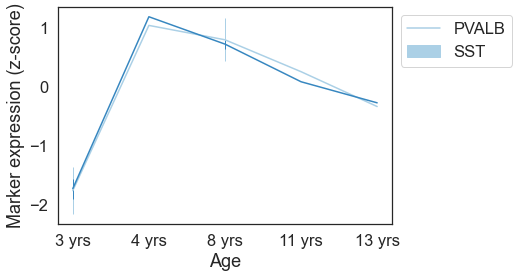

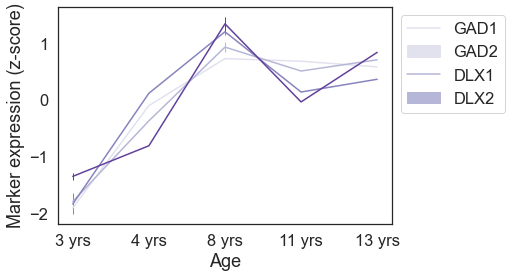

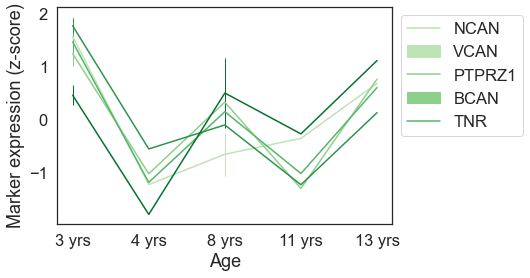

In [14]:
fignum = ['H', 'I', 'J']
colors = ['Blues', 'Purples', 'Greens']
for j,sets in enumerate([[0,1],[2,3,4,5],[6,7,8,9,10]]):
    if j==2:
        my_palette = {c: sns.color_palette(colors[j], n_colors=(len(sets)+1)).as_hex()[c+1] for c in np.arange(len(sets))}
    else:
        my_palette = {c: sns.color_palette(colors[j], n_colors=len(sets)).as_hex()[c] for c in np.arange(len(sets))}
    figure = plt.figure()
    for i, marker in enumerate([markers[x] for x in sets]):
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
        donor = wide.groupby(['donor_id']).mean().reset_index().sort_values('rank')
        donor = donor.groupby(['rank']).std().reset_index().sort_values('rank')
        wide = wide[wide.sa>-1]
        wide = wide.groupby(['age']).mean().reset_index().sort_values('rank')
        x = wide['rank'].values
        y = stats.zscore(wide[marker].values)
        yerr = donor[marker].values/np.sqrt(2)
        plt.plot(x,y , color=my_palette[i])
        plt.fill_between(x,y+yerr, y-yerr, color=my_palette[i])
        #plt.scatter(wide['rank'].values, stats.zscore(wide[marker].values), s=50,  color=my_palette[sets[i]])  # color='w', edgecolors='k'
        plt.xticks(wide['rank'].values, cbpd_wide)
        plt.ylabel('Marker expression (z-score)')
        plt.xlabel('Age')
    plt.legend([markers[x] for x in sets], loc='upper left', bbox_to_anchor=(1, 1))
    stats.f_oneway(wide.iloc[0, 5:9], wide.iloc[1, 5:9], wide.iloc[2, 5:9])
    plt.savefig('/Users/monaminishio/Desktop/HOME8/SurfaceArea/scripts/figures/Figure2/Fig2'+fignum[j]+'.eps',  format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


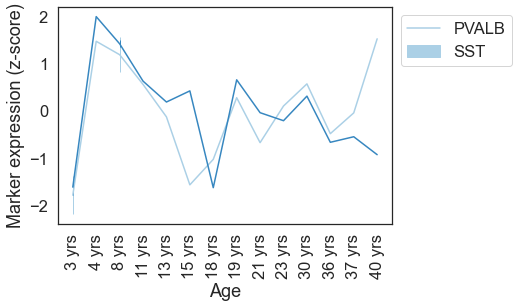

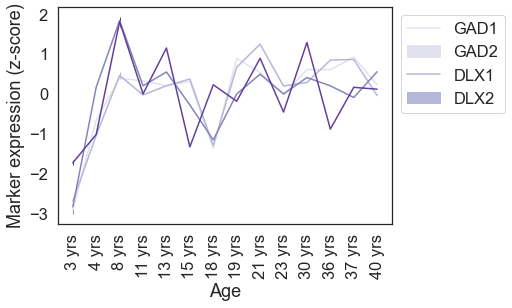

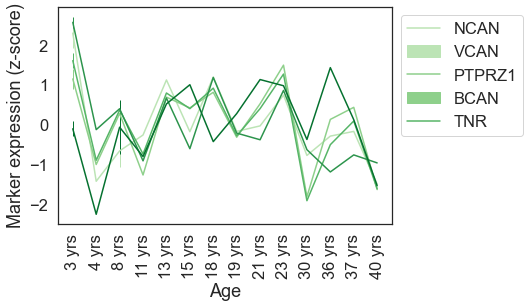

In [15]:
fignum = ['H', 'I', 'J']
colors = ['Blues', 'Purples', 'Greens']
for j,sets in enumerate([[0,1],[2,3,4,5],[6,7,8,9,10]]):
    if j==2:
        my_palette = {c: sns.color_palette(colors[j], n_colors=(len(sets)+1)).as_hex()[c+1] for c in np.arange(len(sets))}
    else:
        my_palette = {c: sns.color_palette(colors[j], n_colors=len(sets)).as_hex()[c] for c in np.arange(len(sets))}
    figure = plt.figure()
    for i, marker in enumerate([markers[x] for x in sets]):
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide+juveniles+adults], :]
        donor = wide.groupby(['donor_id']).mean().reset_index().sort_values('rank')
        donor = donor.groupby(['rank']).std().reset_index().sort_values('rank')
        wide = wide[wide.sa>-1]
        wide = wide.groupby(['age']).mean().reset_index().sort_values('rank')
        x = wide['rank'].values
        y = stats.zscore(wide[marker].values)
        yerr = donor[marker].values/np.sqrt(2)
        plt.plot(x,y , color=my_palette[i])
        plt.fill_between(x,y+yerr, y-yerr, color=my_palette[i])
        #plt.scatter(wide['rank'].values, stats.zscore(wide[marker].values), s=50,  color=my_palette[sets[i]])  # color='w', edgecolors='k'
        plt.xticks(wide['rank'].values, cbpd_wide+['15 yrs']+adults, rotation=90)
        plt.ylabel('Marker expression (z-score)')
        plt.xlabel('Age')
    plt.legend([markers[x] for x in sets], loc='upper left', bbox_to_anchor=(1, 1))
    stats.f_oneway(wide.iloc[0, 5:9], wide.iloc[1, 5:9], wide.iloc[2, 5:9])
    plt.savefig('/Users/monaminishio/Desktop/HOME8/SurfaceArea/scripts/figures/Figure2/Fig2'+fignum[j]+'.eps',  format='eps')

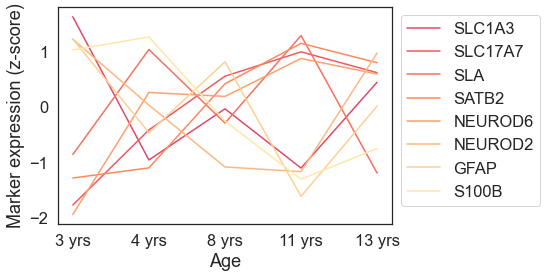

In [16]:
my_palette = {i: sns.color_palette("magma", n_colors=len(markers)).as_hex()[i] for i in np.arange(len(markers))}
for sets in [list(np.arange(11,19))]:
    figure = plt.figure()
    for i, marker in enumerate([markers[x] for x in sets]):
        wide = gene_columns.loc[[x for x in gene_columns.index if gene_columns.loc[x,'age'] in cbpd_wide], :]
        donor = wide.groupby(['donor_id']).mean().reset_index().sort_values('rank')
        donor = donor.groupby(['rank']).std().reset_index().sort_values('rank')
        wide = wide[wide.sa>-1]
        wide = wide.groupby(['age']).mean().reset_index().sort_values('rank')
        x = wide['rank'].values
        y = stats.zscore(wide[marker].values)
        yerr = donor[marker].values/np.sqrt(2)
        plt.plot(x,y , color=my_palette[sets[i]])
        #plt.fill_between(x,y+yerr, y-yerr, color=my_palette[sets[i]])
        #plt.scatter(wide['rank'].values, stats.zscore(wide[marker].values), s=50,  color=my_palette[sets[i]])  # color='w', edgecolors='k'
        plt.xticks(wide['rank'].values, cbpd_wide)
        plt.ylabel('Marker expression (z-score)')
        plt.xlabel('Age')
    plt.legend([markers[x] for x in sets], loc='upper left', bbox_to_anchor=(1, 1))
    stats.f_oneway(wide.iloc[0, 5:9], wide.iloc[1, 5:9], wide.iloc[2, 5:9])